## **Import Library**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

## **Dataset Collection and Description**

In [ ]:
df = pd.read_csv('US_Accidents_March23_sampled_500k.csv')
df.shape
df.head()

<ipython-input-3-04c6c81fb0bf>:1: DtypeWarning: Columns (35,36,37,38,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('US_Accidents_March23_sampled_500k.csv')


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,...,False,False,False,False,True,False,Day,Day,Day,Day
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,...,False,False,False,False,True,False,Day,Day,Day,Day
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,...,False,False,False,False,False,False,Night,Night,Night,Night


In [ ]:
df['Severity'].value_counts()

Severity
2    40333
3     8494
4     1292
1      423
Name: count, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50542 entries, 0 to 50541
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     50542 non-null  object 
 1   Source                 50542 non-null  object 
 2   Severity               50542 non-null  int64  
 3   Start_Time             50542 non-null  object 
 4   End_Time               50542 non-null  object 
 5   Start_Lat              50542 non-null  float64
 6   Start_Lng              50542 non-null  float64
 7   End_Lat                28102 non-null  float64
 8   End_Lng                28102 non-null  float64
 9   Distance(mi)           50542 non-null  float64
 10  Description            50542 non-null  object 
 11  Street                 50472 non-null  object 
 12  City                   50542 non-null  object 
 13  County                 50542 non-null  object 
 14  State                  50542 non-null  object 
 15  Zi

In [ ]:
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,ID,object
1,Source,object
2,Severity,int64
3,Start_Time,object
4,End_Time,object
5,Start_Lat,float64
6,Start_Lng,float64
7,End_Lat,float64
8,End_Lng,float64
9,Distance(mi),float64


In [ ]:
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,bool,6
1,int64,1
2,float64,12
3,object,27


## **Data Preprocessing**


*   Handling of missing values: Given the huge amount of data, the features containing null values >40% have been eliminated (for better prediction accuracy)
*   Checked for duplicates and dropped any if present using drop_duplicates()
*   Convert Categorical columns to numerical using one-hot encoding/label encoding
*   Given the large number of features leveraged PCA for Dimensionality Reduction to select the optimal features that explain the most variance in the data


### **Handling Missing Values**

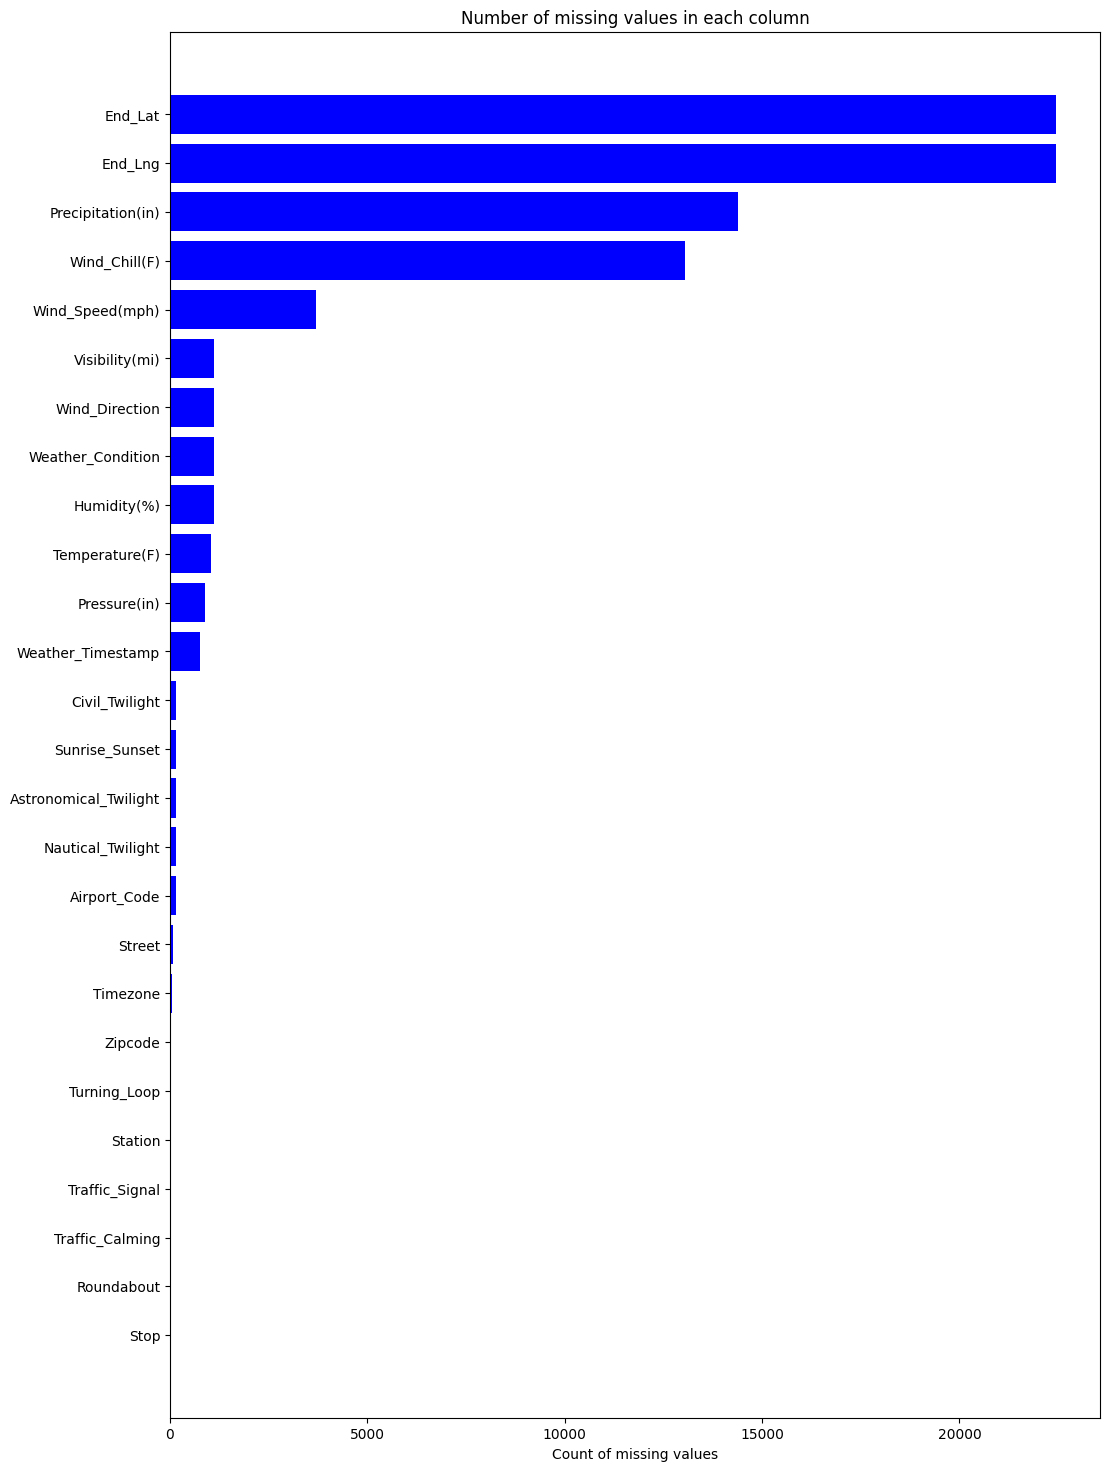

In [ ]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name','missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.5
fig,ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind,missing_df.missing_count.values,color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [ ]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['columns_name','missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] /df.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.4]

,columns_name,missing_count,missing_ratio
7,End_Lat,22440,0.443987
8,End_Lng,22440,0.443987


In [ ]:
missin = missing_df.loc[missing_df['missing_ratio']>0.4]
removelist = missin['columns_name'].tolist()
removelist

['End_Lat', 'End_Lng']

In [ ]:
df.drop(['End_Lat', 'End_Lng'], axis=1, inplace=True)

In [ ]:
df.shape

(50542, 44)

### **Encoding Categorical Data**

In [ ]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns = [col for col in categorical_columns if not isinstance(df[col].iloc[0], bool)]

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(df[categorical_columns])

# Create a DataFrame with the one-hot encoded columns
# Used get_feature_names_out() to get the column names for the encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the one-hot encoded dataframe with the original dataframe
df_encoded = pd.concat([df, one_hot_df], axis=1)

# Drop the original categorical columns
df_encoded = df_encoded.drop(categorical_columns, axis=1)
df_encoded.head(2)

### **Dimensionality Reduction using PCA**

## **Research Question 1: What are the primary factors contributing to the severity of traffic collisions in the United States?**

Using Exploratory Data Analysis Techniques to answer this question

In [ ]:
states = df.State.unique()

<Axes: >

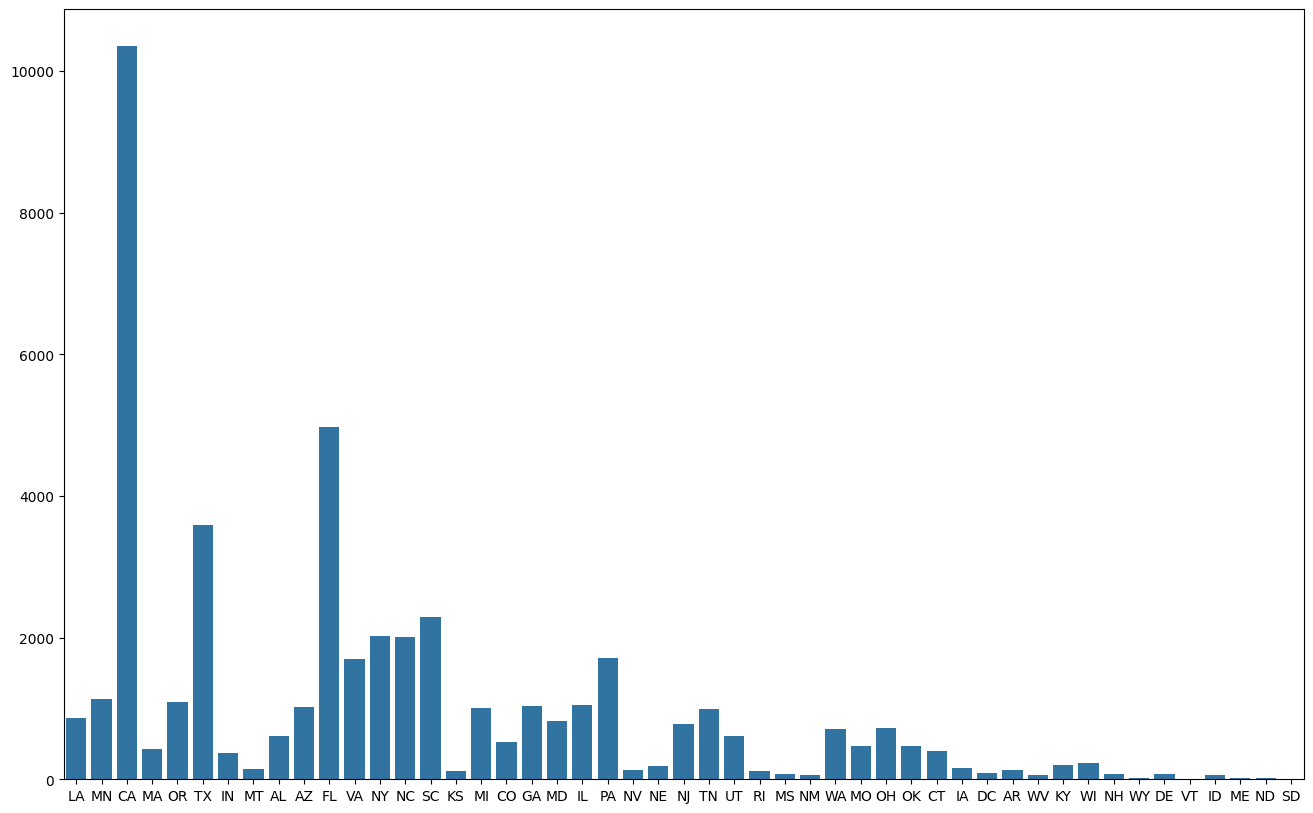

In [ ]:
count_by_state=[]
for i in df.State.unique():
    count_by_state.append(df[df['State']==i].count()['ID'])

fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(x=states,y=count_by_state)

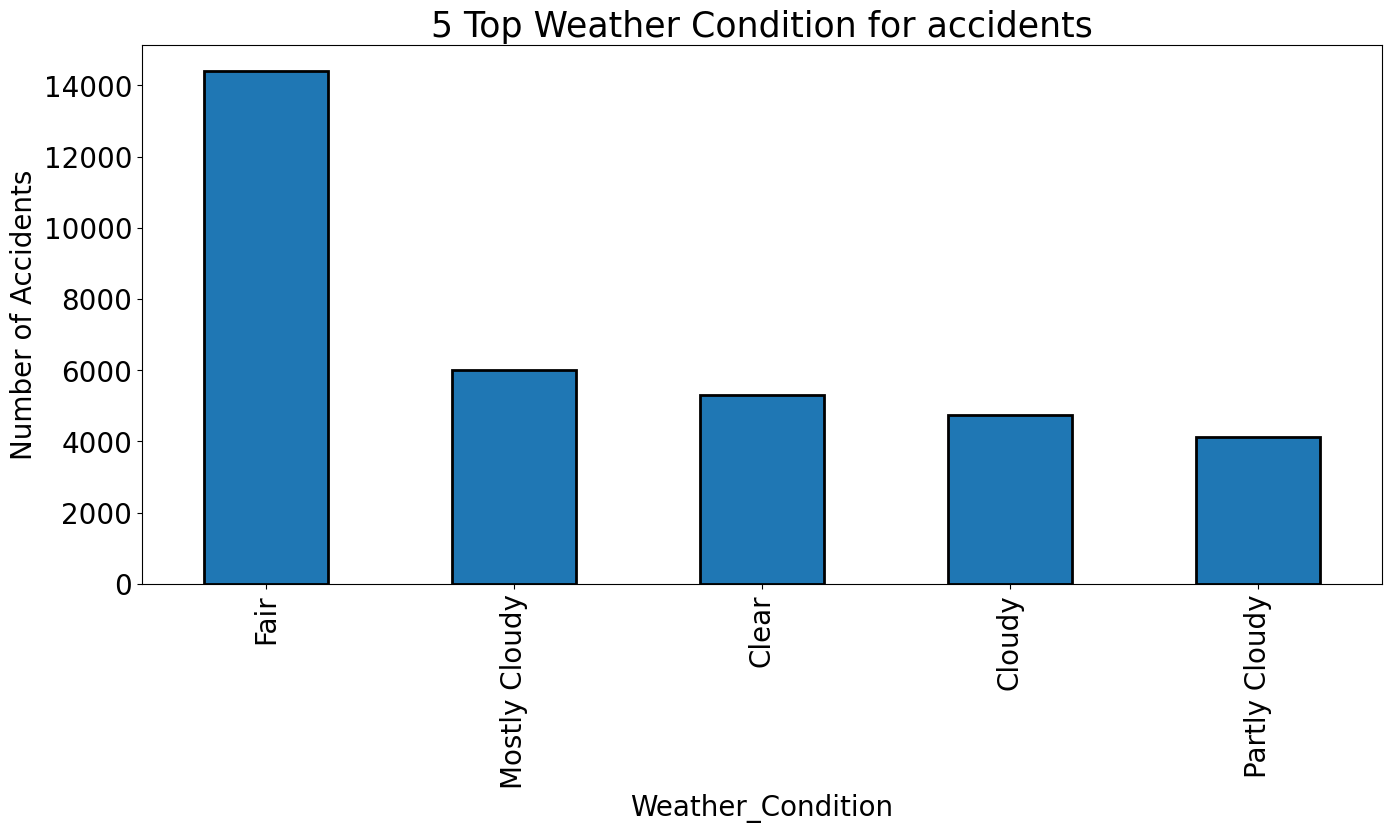

In [ ]:
fig, ax=plt.subplots(figsize=(16,7))
df['Weather_Condition'].value_counts().sort_values(ascending=False).head(5).plot.bar(width=0.5,edgecolor='k',align='center',linewidth=2)
plt.xlabel('Weather_Condition',fontsize=20)
plt.ylabel('Number of Accidents',fontsize=20)
ax.tick_params(labelsize=20)
plt.title('5 Top Weather Condition for accidents',fontsize=25)
plt.show()